# 2. 动态量化

- 在PyTorch中，Eager模式量化（Eager Mode Quantization）是一种较为灵活但需要手动操作的量化方式。其中训练后动态量化（Post-Training Dynamic Quantization）是最容易上手且效果显著的量化方法。
    - 该量化方法，只涉及一个API函数quantize_dynamic。

## 2.1. 动态量化的API说明

### (1) 动态量化的作用

- 动态量化只在权重进行量化（从FP32到INT8），而激活在运行时动态量化。计算流程：
    - **权重**：提前量化好（离线）
    - **激活**：前向传播时实时量化（在线）
    - **计算**：INT8计算，结果反量化为FP32

- 动态量化的主要优势
    - **内存减少**：模型大小减少约4倍
    - **推理加速**：特别适合CPU推理
    - **精度损失小**：通常<1%的精度损失
    - **无需校准数据**：不需要验证集做校准
    - 使用简单，容易作为入门上手。

- 适用范围与场景
    - NLP模型（特别适合Transformer、BERT等现代NLP模型的部署优化）
    - RNN/LSTM等序列模型
    - 全连接层为主的模型
    - 不适合：大量Conv层的CNN模型（需用静态量化）

- 使用动态量化的注意事项：
    - 模型必须在eval()模式下量化
    - 动态量化主要针对CPU推理优化
    - 某些层（如BatchNorm）可能不适合动态量化
    - LSTM等序列模型量化效果显著

### (2) 动态量化API函数quantize_dynamic及其相关类说明

- quantize_dynamic函数的原型定义与参数说明：
    - 将浮点模型转换为动态量化模型（即仅权重量化）。此过程会用仅权重量化的动态版本替换指定的模块，并输出量化后的模型。
    - 最简单的用法是提供dtype参数，可选值为float16或qint8。、
    - 默认情况下，仅权重量化会应用于具有大量权重的层，例如Linear和RNN变体。
    - 通过使用qconfig和mapping可以实现更精细的控制，其作用与quantize()类似。如果提供了qconfig，dtype参数将被忽略。
```python
torch.ao.quantization.quantize_dynamic(
    model,     # 需要量化的模型。
    qconfig_spec=None, # 指定哪些类型的模块需要被量化（量化范围控制）
    dtype=torch.qint8, # 指定量化后权重的数据类型（量化精度控制）
    mapping=None, # 指定原始模块类型到量化模块类型的映射（量化实现控制）
    inplace=False   # 对模型是否进行原地转换，即是否直接修改原始模块。True表示原地量化，False表示在副本上量化。
)
```

- dtype参数可以指定的类型目前只有下面两种（其他都不支持）：
    - torch.qint8:    "有符号8位整数 (-128 to 127)",找个是缺省指定的类型。
    - torch.float16:  "16位浮点 (半精度)",

- qconfig_spec参数是quantize_dynamic函数中最核心、最常用的参数，它决定了模型中哪些层会被量化以及如何量化。该参数有两种使用格式：
    - 集合格式：指定要量化的层类型或者子模块名，在这种情况下，dtype 参数用于指定位宽。
    - 字典格式：将子模块的名称或类型映射到量化配置，对应的量化配置qconfig应用与指定的模块名称或者类型的所有子模块（当然子模块有自己的qconfig例外）。
        - 字典中的量化配置必须是QConfig类型。可以使用`from torch.ao.quantization import get_default_qconfig`函数得到一些预置的QConfig对象。

- mapping参数在quantize_dynamic函数中用于精确控制哪些类型的模块应该被量化以及使用什么样的量化配置。它是动态量化中实现细粒度控制的关键参数。mapping参数是字典格式，字典的字段可以是子模块类型或者子模块名称，其对用的值可以可以是映射的量化类型（该配置可以用更加细的粒度指定量化后的模块类型）。

- get_default_qconfig函数说明
    - `get_default_qconfig(backend='x86', version=0)`
        - PyTorch中针对不同硬件平台优化的预设量化配置，它们在量化策略、观察器选择、性能特征上各有侧重。
        - backend可以指定的值有：
            - `x86` (default)：通用x86架构CPU，兼容性最好，通用性强，适合通用CPU推理、开发测试。
            - `fbgemm`：x86服务器CPU，高性能矩阵运算优化，适合数据中心、服务器端推理。
            - `qnnpack`：ARM架构移动端CPU，低功耗、实时性优化，适合手机、嵌入式设备。
            - `onednn`：Intel CPU (支持AVX-512)，Intel深度优化，适合Intel服务器、桌面CPU。

In [18]:
import torch
from torch.ao.quantization import get_default_qconfig
print(get_default_qconfig("x86"))

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


- QConfig类说明：
    - `torch.ao.quantization.qconfig.QConfig(activation, weight)`
        - activation参数：设置激活函数的量化类型。
        - weight参数：设置权重的量化类型。
    - 通过分别为激活值和权重提供设置（观察器类）来描述如何量化某一层或网络的某一部分。请注意：
        - QConfig 需要包含观察器类（如 MinMaxObserver）或可在调用时返回实例的可调用对象，而不是具体的观察器实例本身。量化准备函数会为每一层多次实例化观察器。
        - 观察器类通常具有合理的默认参数，但可以使用 with_args 方法（其行为类似于 functools.partial）来覆盖这些参数。观察器类在torch.ao.quantization.observer模块中定义。常用的是MinMaxObserver。
            - 可以使用default_observer获取默认的观察器。

In [21]:
from torch.ao.quantization.qconfig import QConfig
from torch.ao.quantization.observer import MinMaxObserver, default_observer, default_weight_observer
print(default_observer)
print(default_weight_observer)
print(MinMaxObserver.with_args(dtype=torch.qint8))
print(default_observer.with_args(dtype=torch.qint8))

my_qconfig = QConfig(
    activation=MinMaxObserver.with_args(dtype=torch.qint8),  # 注意不是MinMaxObserver对象，而是类或者可调用对象
    weight=default_observer.with_args(dtype=torch.qint8),
)
print(my_qconfig)
my_qconfig = QConfig(
    activation=MinMaxObserver,  # 注意不是MinMaxObserver对象，而是类或者可调用对象
    weight=default_weight_observer,
)
print(my_qconfig)

functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, quant_min=0, quant_max=127){}
functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){}
functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8){}
functools.partial(functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, quant_min=0, quant_max=127){}, dtype=torch.qint8){}
QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8){}, weight=functools.partial(functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, quant_min=0, quant_max=127){}, dtype=torch.qint8){})
QConfig(activation=<class 'torch.ao.quantization.observer.MinMaxObserver'>, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})


- 代码说明：
    - 我们这儿说明QConfig的构造，其中的不同的观察器使用，不在这个展开说明。
    - 注意：
        - activation参数指定的是观察器类，而不是观察器对象。我们使用with_args设置类的默认值初始值，并返回一个可调用对象或者类。

### (3) quantize_dynamic函数的应用-qconfig_spec参数

In [64]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleModel()
model.eval()

# qconfig_spec参数的使用 - 类型 -----------------------------------
quantized_type = torch.quantization.quantize_dynamic(
    model, 
    qconfig_spec={nn.Linear, nn.LSTM},   # 指定的类型可以在网络中不存在
    dtype=torch.qint8  # 默认，最常用
)
print(quantized_type)
quantized_name = torch.quantization.quantize_dynamic(
    model,
    qconfig_spec={"fc1", "fc2", "fc3", "fc4"},  # 子模块名不能在集合形式使用。
    dtype=torch.float16  # 半精度浮点
)
print("*" * 100)
print(quantized_name)
line_qconfig = QConfig(
    activation=MinMaxObserver,  # 注意不是MinMaxObserver对象，而是类或者可调用对象
    weight=default_weight_observer.with_args(dtype=torch.qint8),
)

quantized_dict = torch.quantization.quantize_dynamic(
    model, 
    qconfig_spec={
        # nn.Linear: line_qconfig,
        # nn.Linear: get_default_qconfig("x86")
        # nn.Linear:torch.quantization.default_dynamic_qconfig
        "fc1":torch.quantization.default_dynamic_qconfig
    },
    dtype=torch.float16   # 该参数被config的设置覆盖，该参数设置无效。
)
print("*" * 100)
print(quantized_dict)

SimpleModel(
  (fc1): DynamicQuantizedLinear(in_features=784, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=256, out_features=128, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc3): DynamicQuantizedLinear(in_features=128, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)
****************************************************************************************************
SimpleModel(
  (fc1): DynamicQuantizedLinear(in_features=784, out_features=256, dtype=torch.float16)
  (fc2): DynamicQuantizedLinear(in_features=256, out_features=128, dtype=torch.float16)
  (fc3): DynamicQuantizedLinear(in_features=128, out_features=10, dtype=torch.float16)
)
****************************************************************************************************
SimpleModel(
  (fc1): DynamicQuantizedLinear(in_features=784, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): Linear(i

- 代码说明：
    - 观察器使用的类型只支持如下类型：
        -  (torch.qint8, torch.quint8, torch.quint4x2, torch.qint32, torch.int8, torch.uint8, torch.int16, torch.int32, torch.float8_e5m2, torch.float8_e4m3fn, torch.uint16)
    - dtype只支持：torch.qint8与torch.float16两种。
    - 当qconfig_spec参数使用字典指定量化类的量化配置，则dtype参数无效。
    - 对于动态量化，模型需要使用eval函数切换为评估模式。动态量化一般都用于推理。
    - 注意：
        - 配置中集合格式使用名称无效。只有在字典格式才有效。

### (4) quantize_dynamic函数的应用-mapping参数

In [67]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.ao.quantization import get_default_qconfig

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleModel()
model.eval()
# mapping参数的使用 ------------------------------------
linear_spec = QConfig(
    activation=MinMaxObserver,  # 注意不是MinMaxObserver对象，而是类或者可调用对象
    weight=default_weight_observer.with_args(dtype=torch.qint8),
)

quantized_mapping = torch.quantization.quantize_dynamic(
    model, 
    # qconfig_spec={
    #     # nn.Linear: linear_spec,
    #     # nn.Linear: get_default_qconfig("x86")
    #     # nn.Linear:torch.quantization.default_dynamic_qconfig
    #     # "fc2":torch.quantization.default_dynamic_qconfig
    # },
    dtype=torch.float16,
    mapping={
        nn.Linear: torch.nn.quantized.dynamic.Linear, # 字典的值value，使用量化后的类型。
        # "fc1": torch.nn.quantized.dynamic.Linear, # 字典的关键字key不能指定模块名。
    }
)
print("*" * 100)
print(quantized_mapping)

****************************************************************************************************
SimpleModel(
  (fc1): DynamicQuantizedLinear(in_features=784, out_features=256, dtype=torch.float16)
  (fc2): DynamicQuantizedLinear(in_features=256, out_features=128, dtype=torch.float16)
  (fc3): DynamicQuantizedLinear(in_features=128, out_features=10, dtype=torch.float16)
)


- 代码说明：
    - 使用mapping参数，则qconfig_spec参数必须设置为None，否则mapping无效，
    - 在mapping的字典中字段不能使用模块名。
    - 在字典中值，只能指定量化后的类型。

## 2.2. 动态量化应用

- 我们使用一个文本分类的模型来说明动态量化的使用。
    - 下载模型：`git clone https://www.modelscope.cn/BAAI/bge-reranker-v2-m3.git`
    - 该模型是北京人工智能研究院提供，支持多语言（包含中英文）。

- 使用Pipeline进行推理。

In [13]:
from transformers import pipeline
import time
semantic_cls = pipeline("text-classification", 'F:/03Models/nlp_structbert_emotion-classification_chinese-base')
print(type(semantic_cls))
print(type(semantic_cls.model))
print(type(semantic_cls.model.config))
print(type(semantic_cls.tokenizer))
print(type(semantic_cls.processor))
print(type(semantic_cls.image_processor))

result = semantic_cls(inputs='新年快乐！')
print(result)
# 预热
for i in range(10):
    semantic_cls(inputs='新年快乐！')

# 10次推理的时间
start = time.time()
for i in range(100):
    semantic_cls(inputs='新年快乐！')

print("推理耗时：", time.time() - start)

Device set to use cuda:0


<class 'transformers.pipelines.text_classification.TextClassificationPipeline'>
<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>
<class 'transformers.models.bert.configuration_bert.BertConfig'>
<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
<class 'NoneType'>
<class 'NoneType'>
[{'label': '喜好', 'score': 0.7755956649780273}]
推理耗时： 0.6558141708374023


- 分析模型结构

In [14]:
from transformers.pipelines.text_classification import TextClassificationPipeline
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast

# 加载模型
model = BertForSequenceClassification.from_pretrained('F:/03Models/nlp_structbert_emotion-classification_chinese-base')
tokenizer = BertTokenizerFast.from_pretrained('F:/03Models/nlp_structbert_emotion-classification_chinese-base')
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

- 代码说明：
    - 在输出的模型中，我们观察，主要的层为nn.Linear类型与nn.Embedding类型。激活函数使用Tanh与GELUActivation，其他的操作有dropout，LayerNorm。

- 进行量化操作
    - 我们知道对动态量化：
        - 不支持的层类型：
            - nn.Conv1d/2d/3d
            - nn.MultiheadAttention
            - nn.Activations（不改变，保持fp32计算）
        - 支持的层类型：
            - nn.Linear
            - nn.LSTM
            - nn.GRU
            - nn.RNNCell
            - nn.GRUCell
            - nn.LSTMCell
            - nn.EmbeddingBag
            - nn.Embedding（）

In [20]:
import warnings
warnings.filterwarnings("ignore")

from transformers.pipelines.text_classification import TextClassificationPipeline
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast

import torch
import torch.nn as nn
from torch.ao.quantization.qconfig import QConfig
from torch.ao.quantization.observer import MinMaxObserver, default_observer, default_weight_observer
from torch.ao.quantization import quantize_dynamic
# 加载模型
model = BertForSequenceClassification.from_pretrained('F:/03Models/nlp_structbert_emotion-classification_chinese-base')
tokenizer = BertTokenizerFast.from_pretrained('F:/03Models/nlp_structbert_emotion-classification_chinese-base')

# 量化模型
quantized_model = quantize_dynamic(
    model, 
    qconfig_spec={
        torch.nn.Linear: QConfig(
            activation=MinMaxObserver.with_args(dtype=torch.qint8), 
            weight=default_weight_observer.with_args(dtype=torch.qint8)
        ), 
        torch.nn.Embedding: torch.ao.quantization.float_qparams_weight_only_qconfig
    }, 
    dtype=torch.qint8  # 默认，最常用
)

print(quantized_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): QuantizedEmbedding(num_embeddings=21128, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      (position_embeddings): QuantizedEmbedding(num_embeddings=512, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      (token_type_embeddings): QuantizedEmbedding(num_embeddings=2, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (key): Dyn

- 代码说明：
    - 我们通过观察上面的输出得知，Linear与Embedding层都已经替换成量化类型。
    - 特别注意：
        - Embedding层只支持float_qparams_weight_only_qconfig量化配置。

- 使用量化模型进行推理
    - 记得使用eval切换到推理模式

In [50]:
import warnings
warnings.filterwarnings("ignore")

from transformers.pipelines.text_classification import TextClassificationPipeline
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast

import torch
import torch.nn as nn
from torch.ao.quantization.qconfig import QConfig
from torch.ao.quantization.observer import MinMaxObserver, default_observer, default_weight_observer
from torch.ao.quantization import quantize_dynamic
# 加载模型
model = BertForSequenceClassification.from_pretrained('F:/03Models/nlp_structbert_emotion-classification_chinese-base')
tokenizer = BertTokenizerFast.from_pretrained('F:/03Models/nlp_structbert_emotion-classification_chinese-base')

model.eval()
# model.train()

# 量化模型
# quantized_model = quantize_dynamic(
#     model, 
#     qconfig_spec={
#         torch.nn.Linear: QConfig(
#             activation=MinMaxObserver.with_args(dtype=torch.qint8), 
#             weight=default_weight_observer.with_args(dtype=torch.qint8)
#         ), 
#         torch.nn.Embedding: torch.ao.quantization.float_qparams_weight_only_qconfig,
#     }, 
#     dtype=torch.qint8,  # 默认，最常用
# )
quantized_model = quantize_dynamic(
    model, 
    qconfig_spec={torch.nn.Linear}, 
    dtype=torch.float16,  # 默认，最常用
)
model_inputs = tokenizer("新年快乐！", return_tensors="pt")
print("tokens：", model_inputs)
# 推理输出
outputs = quantized_model(**model_inputs)
# outputs = model(**model_inputs)
print(outputs.logits)
# 转换为分类概率
prob = torch.sigmoid(outputs.logits)
print(prob)
max_value, max_id = torch.max(prob, dim=1)
print(max_id.item(), max_value.item())
# 类别ID
predicted_class_id = prob.argmax().item()
print("识别ID", predicted_class_id)
# 转换为可阅读标签
label = model.config.id2label[predicted_class_id]
print("识别情绪类别：", label)

tokens： {'input_ids': tensor([[ 101, 3173, 2399, 2571,  727, 8013,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
tensor([[-6.5389, -5.5411, -5.3175,  1.2398, -3.2422, -0.8424, -6.5756]],
       grad_fn=<AddBackward0>)
tensor([[0.0014, 0.0039, 0.0049, 0.7755, 0.0376, 0.3010, 0.0014]],
       grad_fn=<SigmoidBackward0>)
3 0.7755334377288818
识别ID 3
识别情绪类别： 喜好


- 代码说明：
    - 我们从量化模型的推理看出，在qint8类型的时候，量化的推理结果明显受精度影响。
    - 在代码中，还可以测试model.train()与model.eval()切换的情况。在当前这个模型中似乎没有什么影响（实际涉及BatchNorm等操作的时候，还有有影响的）。

## 2.3. 动态量化性能分析

- 性能分析，我们主要看看量化模型的存储大小，以及推理时间。
    - 我们对原模型，qint8与float16的模型进行比较。

- 获取模型的存储大小计算。

In [87]:
def get_model_size(m):
    # 计算总参数量
    total_params = sum(p.numel() for p in m.parameters())
    # 计算可训练参数量
    trainable_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
    # 计算模型大小（假设参数为float32，每个参数4字节）
    param_size = total_params * 4  # 字节
    # 转换为更易读的单位
    size_mb = param_size / (1024 * 1024)
    return total_params, trainable_params, size_mb  # 从可阅读性上考虑，建议采用字典

- 模型的推理时间计算。

In [88]:
def measure_inference_time(model, input_tensor, num_runs=1000):
    import torch
    import time
    model.eval()
    # 预热
    with torch.no_grad():
        for _ in range(20):
            _ = model(**input_tensor)
    # 同步CUDA（如果使用GPU）
    if torch.cuda.is_available():
        torch.cuda.synchronize()  # 阻塞，直到所有数据移动到GPU
    # 开始计时
    start_time = time.perf_counter()  # CPU或者GPU实际运算时间
    
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(**input_tensor)
    # 再次同步
    if torch.cuda.is_available():
        torch.cuda.synchronize()   # 阻塞，直到GPU上所有计算完成（GPU是多核并行运算的）
    end_time = time.perf_counter()
    
    total_time = end_time - start_time
    avg_time = total_time / num_runs
    return avg_time * 1000   # 毫秒

- 性能比较分析与可视化

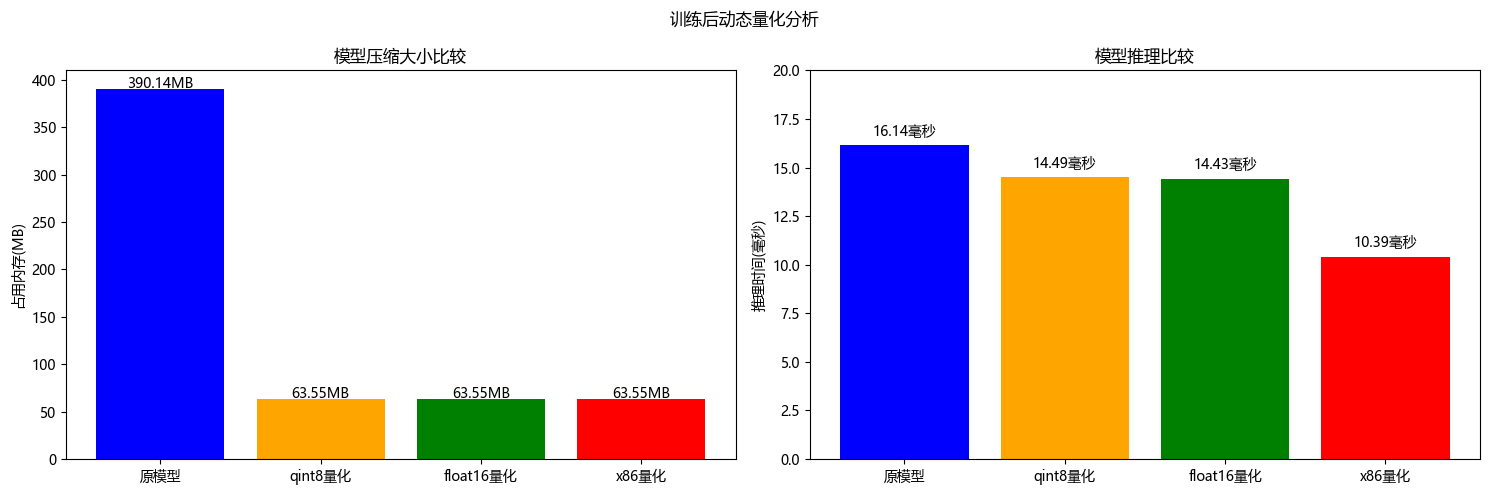

In [89]:
import warnings
warnings.filterwarnings("ignore")

from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast

import torch
import torch.nn as nn
from torch.ao.quantization.qconfig import QConfig
from torch.ao.quantization.observer import MinMaxObserver, default_observer, default_weight_observer
from torch.ao.quantization import quantize_dynamic, get_default_qconfig

# 加载模型
model = BertForSequenceClassification.from_pretrained('F:/03Models/nlp_structbert_emotion-classification_chinese-base')
tokenizer = BertTokenizerFast.from_pretrained('F:/03Models/nlp_structbert_emotion-classification_chinese-base')

model.to(torch.float32)

model.eval()

# 量化模型
model_qint8 = quantize_dynamic(
    model, 
    qconfig_spec={torch.nn.Linear}, 
    dtype=torch.qint8,  # 默认，最常用
)
model_float16 = quantize_dynamic(
    model, 
    qconfig_spec={torch.nn.Linear}, 
    dtype=torch.float16,  # 默认，最常用
)
# 量化模型
model_x86 = quantize_dynamic(
    model, 
    qconfig_spec={
        torch.nn.Linear:get_default_qconfig("x86"), 
    }, 
)
model_inputs = tokenizer("新年快乐！", return_tensors="pt")

quant_method = {
    "原模型": model,
    "qint8量化": model_qint8,
    "float16量化": model_float16,
    "x86量化": model_x86
}

# 模型性能分析
analysis_rensult = {}
for model_type, m in quant_method.items():
    _, _, model_mems = get_model_size(m)
    infer_time = measure_inference_time(m, model_inputs, num_runs=1)
    analysis_rensult[model_type] = [model_mems, infer_time]

# 可视化
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["Microsoft YaHei"]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

types = list(analysis_rensult.keys())
mems = [analysis_rensult[ty][0] for ty in types]
tims =  [analysis_rensult[ty][1] for ty in types]
axes[0].bar(types, mems, color=['blue', 'orange', 'green', 'red'])
axes[0].set_ylabel('占用内存(MB)')
axes[0].set_title('模型压缩大小比较')
axes[0].set_ylim([0, 410])
for i, v in enumerate(mems):
    axes[0].text(i, v + 1, f'{v:.2f}MB', ha='center')

axes[1].bar(types, tims, color=['blue', 'orange', 'green', 'red'])
axes[1].set_ylabel('推理时间(毫秒)')
axes[1].set_title('模型推理比较')
axes[1].set_ylim([0, 20])
for i, v in enumerate(tims):
    axes[1].text(i, v + 0.5, f'{v:.2f}毫秒', ha='center')

plt.suptitle("训练后动态量化分析")
plt.tight_layout()
plt.show()


- 代码说明：
    - 代码中时间使用的是毫秒，所有原来计算出的秒，我们乘以1000转换为毫秒。
    - 代码中预热是保证计算的稳定性。
    - 为了更好观察效果，使用代码`model.to(torch.float32)`把模型的类型设置为fp32.

----